In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import copy

# Kiểm tra xem có GPU không, nếu không thì dùng CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(nn.Module):
    def __init__(self, backbone='resnet18', n_classes=2):
        super(Model, self).__init__()
        if backbone == 'resnet18':
            self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, n_classes)
        elif backbone == 'mobilenet_v2':
            self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
            num_ftrs = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_ftrs, n_classes)
        else:
            raise ValueError("Unsupported backbone")

    def forward(self, x):
        return self.model(x)


class Learner:
    def __init__(self, model, train_dataloader, val_dataloader, criterion, optimizer):
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
        self.best_acc = 0.0

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in self.train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels % 2  # Đảm bảo nhãn trong khoảng hợp lệ
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(self.train_dataloader.dataset)
        epoch_acc = corrects.double() / len(self.train_dataloader.dataset)
        return epoch_loss, epoch_acc.item()

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        corrects = 0

        with torch.no_grad():
            for inputs, labels in self.val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels % 2  # Đảm bảo nhãn trong khoảng hợp lệ
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(self.val_dataloader.dataset)
        epoch_acc = corrects.double() / len(self.val_dataloader.dataset)

        if epoch_acc > self.best_acc:
            self.best_acc = epoch_acc
            self.best_model_wts = copy.deepcopy(self.model.state_dict())

        return epoch_loss, epoch_acc.item()

    def train(self, num_epochs=25):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.val_epoch()
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        self.model.load_state_dict(self.best_model_wts)
        return self.model

    def test(self, test_dataloader):
        self.model.eval()
        running_loss = 0.0
        corrects = 0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels % 2  # Đảm bảo nhãn trong khoảng hợp lệ
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)

        loss_mean = running_loss / len(test_dataloader.dataset)
        acc_mean = corrects.double() / len(test_dataloader.dataset)
        return acc_mean.item(), loss_mean

    def inference(self, image_tensor):
        self.model.eval()
        with torch.no_grad():
            image_tensor = image_tensor.to(device).unsqueeze(0)
            output = self.model(image_tensor)
            _, pred = torch.max(output, 1)
        return pred.item()

In [14]:
def main():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    dataset = datasets.FakeData(transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    global model
    model = Model(backbone='resnet18', n_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    learner = Learner(model, train_loader, val_loader, criterion, optimizer)
    # trained_model = learner.train(num_epochs=10)

if __name__ == "__main__":
    main()

In [16]:
print(model)

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [17]:
torch.save(model.state_dict(), "trained_model.pth")


<ipython-input-21-dfad203578a5>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_model.pth'))


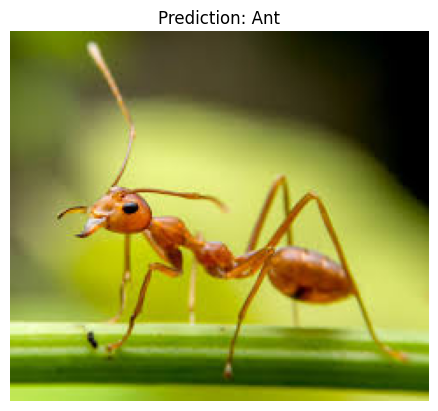

In [21]:
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt


# Chuỗi base64 (rút gọn để minh họa)
image_base64 = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxATEBAPEBIPEBAPDw8QDQ8PDxAPDRAOFREWFhURFRUYHSggGBolGxUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OFxAQGi0dHR0tLS4tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0rLS0tLS0tKy0tLf/AABEIANMA7wMBEQACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAADBAECBQAGB//EAEAQAAEDAgMFBQYEAwYHAAAAAAEAAgMEEQUSIQYxQVFhEyJScZEUFjJCgaEVYrHBIzNTByRDctHwY4KSosLh8f/EABoBAAMBAQEBAAAAAAAAAAAAAAABAgMEBQb/xAAzEQACAgEDBAAEBQMEAwEAAAAAAQIRAwQSIRMxQVEUImFxFVKRofAyQtEFI4GxcsHhM//aAAwDAQACEQMRAD8A8zFKvmZRJocikWMogMMes2gCZlFBRRxVIdEwUckhIjaXEamy3x4pT/pARqIi0lrgQRvB3haKDTplCcjV0RiMXkauiKGAcxbxGUyKwJDUDJyoA6yAIsgCpagRR7UCAPCBC72pAAe1AmAc1WmDBOaqTJBlqqwKFqqxUUITAoQqAqUyiEAcgDkAfRIivnWrEORFZuDAYa5S8QgzXrN42hkOKccYze2MxJsU9n2yyWGvNdmCXTZcKvkN/aFQBsrZmDuyDUjddb5orduXkqcaPFvCUUQAe1bRQwLmrVIZTKrA7KgDrJDIsgCtkAQQgRRwQAGRqQhd7UCAPagAD2oQgbmqkwoGWqrEDc1UmIG4KkwBuCuxFCExoomM5AHIA+ktjXhokOwJ0AZpRtAm6WwZJclsGV7SxuOCrYM9bR1wq6Z1O/8AmMHc5myVtPa/+DrjWSFeTxk7C1xadC0kEdVukc1UActEAFwWiGUIVDOslYHEJAVQBBCAIITEDcEgBvCAYB7UCAuagAL2IECc1AAXNVJioG4KgBuCoQNwVoQF4VIChVDIQByAPqbWLw0SEDFQFsipAQWq0hgnp7Rg3OT2lIPhtc6KRsjeB18uKU8do0hLa7NHaqnbmbOzVkwuTwzJYnfBpmhT3ezAJW1GJQq0MqQgCLJAQUAVQByAIKBA3IGDcgQJwQAJwTECc1IATmpgBc1IAL2qkxUDcFSCgTgrQgD1ohMEVQEIA5AH1prV4RIUNVWBbKqQEFitMYCWNaxGhV0ZVos4QlAzfw1hmp30p3tBfGT04LCVxmnfB0QalBxfc8+6lde1lvuRzsj2V3JPcFnexuU7gONIUtwwbqco3BYF0ZVWBQtKLAqU7Ao5AA3IAG5AijggATgmIE4IAC8IAC8IQAXBUgAvVoli8i1QgRVAQgDkAfX2heESEATAtZNMZNlaA4xq0xoH7OtLLGIqVS5AP0UJa4OH18ljlqcWmXCbjJMJU4eMxtuOqmGW48FZo079g/YOie8xIND0RvAG6gHJHUAG7DhyR1Bi0uG9FSyAKS4eeStTCxSWhPJUpjFJaMqlMBZ9OVW4ALoynYAi0pgCcExAnIAE9AAHhIAD1SBgJFoiRd4WiECKsCEAcgD7C1eEIIEwLJgSFSGGY1UMOyBFlDsFOpcgHoqdZOQDHspJBHAG/lzUwV3+pre6FeixpVG4xKGlRuAqaVLcBQ0qNwAn0qe4BaSjVqYCslF0VKYCs1AOStTGIzYctN4CMtB0VbwFZaLompgKy0atTATlpSqUgEpYiFVgKvQAB6pAwD1oiQDwtEICVQFUwOQB9eY5eJQBA5FAWzJpAWjcqAehahlI0aaJQ2M0YYFm5APRQrNsBlrbXsASRbXqR+wVwdY5v+cmuJpXZfsFz2ZFTAlYFTAiwKOgRYAnQIsAL6dVYC8lOqUhC0lOq3AKyU6akIUkpFamAtJRpqYCktCrUxiU1D0VKYGbU0PRaKYzJqqFWpgZk8BC1jIGJvWqJAvWiEAcrQiiYzkAfV43rx6HRfOigJzp0AWA6p0Br0qhjNmlaspMZqQRrFsB6KNSMKxt3W5C5/b91pJ1iS9u/wBOP8j8DIjWBJxiSAqYUgKOhQAJ0KYAXwoAA+FOwF3wJ2Au+nRYAH06e4QtJTp7gFpKdUpCFZKdWpAIz0itSAzKmiVqQzHrKBaKYzAraMhdOPIJmZIF0oli7lohFExnIA+oRuXl0WGCKFRbVFDDU6GBrUhWUgN6jKwkBsU6xYx5hABJ3AXKSTbpAdhneaZP6jiW/wCTcPod/wBVWWScuOy4X/H8sqfDr0aDQsyS2VAji1AFSxAFHMSAE6JAAHwoAC+FAAXQIsAD4ErAXkgTsBaSnTTELS06rcAnLAqTEIVFOrUgMqqplaYzEraTetFIDzmIUVrkLtxZRNGLIF2IkGqGcgD6lG1eczQZa1SIII0gCshsk2A/ShZSA3KMrGQGzTFYsZSumL3spWHV/emI+SEb/IncEk65/n8/ng1xrat78dvubcVgABoAAABuAHBQZB2lMC2ZIRN0AQSmBF0DIKABlqQgbmoYwTmKQF6hzWjM7cE4q2VGLk6RjRYjnmyWAYR3eZKzlnjKVRXBvlwqEfqPvhV2cotLCqsBKaFOxCE8KtMDNqYVSYjHq6dWmBg11NvWsJ0xnmsRpLagL0cOQlmUQusCEAfWI2LzmajcUaliGo4lFgNxwKGwCshss3IRpUizkBrwBxBDBmcBcC9hfhc8Eo4pZL2lwjuZnV1e+JrmFsYky5pZGMLXF2S+rgCXG1hp+yqeqjirFtTfm+x6ePSKSvwLU2JYj2Ie0NAc27e2DhJa+/KQSDv0J4K3p93NJfz+eSZabFuofwo1U7cza5ocNHxmkGZh69/d1XPOLg+Uc+TZB04fuaHYYi3dNTy9Hxuiv9RmWbl9DPdhfdNf8ne3V7fjpo5BzhmAPo+yLj9UGzE+0q+6Fptqiw2lpaiP/MO79CBYqXKK8/z9TSOl3/0yRem2ugd8Ykj4juueN/EgafVSppkz0s4/U1KTFYZPgeCeW4pqSMXCUe6GyVRBQoYFHKAPKbS1ZdLHTM3uIzW5J5Hsxt+WdemVXN+AeLNEU1IBprlPosHDbBfQzUt26zfqJGtaXuIa0C5J3BbIwq+EY0WORPcQbtHylw0I623HoURnDlNnS9LLbfkbkYCLjUHcVSZytCU8KpMRnTwKkxGZVU6pMDFrKXersDBraTet8eSgPOV9CRqAvRxZr7kmYQuoZ9ehYvOZqPRMWbYDcMahiHWgNaXOIa1urnOIa0eZKzY0m3SBsqHv/lQvcODnubED1se8PqAuOeqwxdN39lZ0LSzrmkN4c57s2drIyzKDaTOCSdBewVRywlFyXZDWm+ZRvubNdHPFF3WEvO8NByg/uumUMuxOPn9jqx9JOl2RlskLmE1MN73cGuJDwBxt16rgzqeOO6cbf3qjshJSfyOj51Xf2m1DXuhjpzG4PLbdo8uvutl3H7r6HFgxdJOrtd7PIzZ8vUcb7PtR6vDcTmjZDVvbllyNMzN1zbvsPn9j5LyHmg90O8b4Z6eXTvLBXxKj6NT1DXta9pu17WuaebXC4PoVzM8RqnTC5krERdMDso5D0TpDsSrcNY/vNAa8bnN0KiUPRrDK1w+UXoXutlfqRxWiiqtBkglyhklSzEBUyhrXOO4AlJK3QzyOzcZmqZal24GzFOV7pqPhHXl+TGoBtsNHU7zoGyC55DVKauLMMXdmViFdJWTNgh0ibbXhpvkP7BVJ7YpHXjxrFDqT7np4cLjZCYWjQtIc4/E4niSpjFJ8nHLLKUtxmbPVRc18L/jhNvNt7fYpR+V7TTURVqa7MfljWhzCU0SpMRnzwqrEZdTTK0wMerpE7Axaui6LaGRoR5/EMM4hehiziPpUDFmzYfiYs2IchYokwLSYe18kcjy5wiuY4yf4YkP+Jbi62nRYzfDXspScexqRBc7pdhdzUw2ma4uJ3AWyttck8Nei69LpY5U5z7eCoZJRfynn8fqWwCTs5artAwhgM38KM7we6BfjpqFk5abD8uJuUvv2PUh1Z05xSX27nmBjZMbRckkDM8m+bTeuScMjk9zOuKj4E4Z2lxcGi+64AvblfkiUWo1Z0xS7hquvysI3l2jRxJOlgpx4bkaSaStntsFxdgp4ow9znRxsZYZW3DWgC2nRdCz4Yz2Thb9rszx5aJTbkvPIWoxwt3GQH81iFeWeFLtQloovijSwjE+1abgB7CA8A3ab7iFxxmpco4tTppYZU/Joh60TOYtmRYEXSHZBKQHntsK7LF2Y+KTT6LSHCcn4N9PDdL7DeAUnZQMbxIu7zK54e/ZGae6TPPbcYg05adtnPBBd+U8Ata45OnR4re99kauzOFiGEE2MkgDpHfoFnH5vm/T7GWpzOcvojXKo5jzOIO7CsZJ8kvxctdHD9CpyKvnX8/iOuH+5icfKN2RqtM4xSViYCU0apMQhNCqTEZ9RTqkwMqppEwMmqoui0jNoD0dI8LukWakIWTAbjCykwGY1jJgWqHva0mNgkd4C8R3+pBWFxv5nS+nP+BoSw2aue49o1tMw6Gz2yTEbrAt0GltVpqNXBY+nifH8/wCzrw5MeLmtz/Y2DSxuYY3ND2kWcHDNm815G9R7cGc8s5y3t8mTNslTO+Evj5AEOaPXX7q1rJLzZtDV5I/UxqTZdrp5Iu1eGs4gC5+63lrHtTpHQ9ZNRTruPT7M08FnlpmaRlkdL3nNB4tt8P6p4ddc9suzJx6iWR0+GeWqqhzHOiN25XHKQTu4H9F19JXuXJ348loMMZflynU/m1BHMLOWnTdm6aXY0dmMYLZDa4LSLsJ7pad+qjLBwp+Dmz445U4vv4PeUlcXXOobpa/VaQjuxuSPIyadwXPc0A5TT9HMWzKQILkAeOqT7RXNbvaw3PKwV5eIRj7O2C6eJv2bmO4mIIiRq892NvXn5KEc+HE8sq/U8XFhj3RPq5Cb3uy+9xvq5JybujvzZVBrHE91h7rxMP5Qlj/pR5k/6mHKsky9oaHtYTb4md9nO43j0T8Ua4Z7JplcBq+1gaT8Te47zH/pZQdcegzQ2yHXxrSzEWkhTEKSwJ2AlNTqkxCM1MqsDOqKRVYAodCvTZRsUj1hILNCNYSYDDFzyYw7SuWchotmXBlyUWi7XLicmyggco5Ax8Jf/eajp/quzOqwwNcn9ETYksQWnUEWIXGm07M06PH45goJtucAeycdxHhPVe7o9TvVM9LBl3K138nhRWFkhD7ODb9y9hqvY6W+Py8WbPMe2w/A4ZoG1FK57M7bljzc5m6EX4aheTlz5Mc3DJTo41qnGTU0DwzFXRvLJHuAjN3MNrOtw1XRixwbUn278HbJuUePJsz7Usy52ZwHfC24IC9OWr2r5b+xhHSJv5khzAMfDn9m9xOa3Zkj5uLfLdZeXklubb/jMdVotsd0PBvV0pEbiBc2sB1TxY5TkkkedFWzydFUspHSSTEPlf8ABGxwJA5uO5q01OnlGe6XC8Lz+h3Sg8qUYdkI1Fe2ola+YEAuaNHgNbHc3DRa5PEnksVHc69/t9zoxweGD21/k9Mx7KiMxRsywjugnQkDou7FpsL+WNujj6M098nyNxRSxhrGhrwBZo4q5aPHFVG0S8LlzZanrLtu5pYdQQeBWS0cmrTMZY5RY0wgjQgrlnCUHTRmefw9nYVkkO5kwzs5XWE+JJ+/5/2dU/nxKXlHoCxWcgN0SYAHwoAWlgTsQlNTqkwEZqdOwMQBeqxDVO6yzkBowzLnmhjbJFyzGFbIuDNKikFY5ebLk0CtKhjLgqQMLCXf3uo6gfqu/Ov9iBpP+mJszS5WlxucoJsN+i4ox3NL2ZpW6MavxiM91zCW2BuD3wfK37r0IaRxdxl+3B249Pkg7i+Tw20mGMLu2hcHg/G2xD2+bV7mjyzUdk1/g03fNyqPX7Cgto2j88luguvI/wBSbep4+hx5v6zP2lwN5LpmEW/xB+67MWojjkscjs0+dRqLPM0kuvZ/E25uANQRxXdOF8rudzzxRq0dUxk7BnuLtvl0IvxXOsblHlUKeRNcG3PW1Lnu/iuybmOLct29GqZ53ie2Mt1foZQxJx5ikItpHOfksepJ1vxJPJYvJ5fLZr8qjfhAafRxkLczRcN0+W+hAVyuqi+TO7ds0INoHR3Le6D8oWmHJkx8RJnCMu4xDti9pa462Nx/ouh6jJJ8oXRikah2qbI0E5dd44hax19cSVGMtL6Y3TVEbmNlY/K8E3be4IWsXDNbbMMuJqlQhj9drDNufE8BxG4tK4tXpag6Zngg03F9meup3hzWvG5wBC4oPdFM5JRp0EyKiSjo0ALyRIAVlhTASmgTsDyYC9YkK1SxBo3rKSAailXHkRSGGyLzs8WWg0cq4nEsOyVQ4jCdopUbdDEaB7LghpD/AOJ2jiLXN9y79UorGoruu5tk7V6F9pKoiNsTPimJb1yAXNvsPqo0WNOTnLtEWCKc+fA+KRmRrHNaQGtG7iABf7LneWW5yTEss4y3JiFXgrHaDLb8wvbyXRi1koOzpesTj80eR7DKNsYEbd2a/T6eiUszz5ot/Q5HLdKxiqYCXNOoOhHRPVyrM68Dk6Z5efZW0naQvA1vldwd58l1Yv8AU6SU128o1jn4pjlJs/3i8xxCSzbPB7oIvewVZdd1eI9v0OjHqccFyM0uEVOdxJiF9A43cW9R1Uxml2jf3DJrISVchMSom08DmNOaWocWl1tch+O3nu/5lcFte+XddjOGWWeSXaMeTK2gw51OIzbM2SMNk5B++w/3wW2K6+5pjzLLJ/sePqpHA8weHFdkFFnSVvcAbuifZlJWc4kcbJcMUkM0WIvZqCf2Uyxp9gXY1IMeDmSRvF84sOipSnH+rlGcsafY9psJiXaQ9k496PTzC4K2zcffK/8AZ52qhUt3s9TZUchxCABvYgQvJGgBWWJMDw7IyvVsgIIik2BZsZUNgGY0rnmhoMFx5IWUiQ9cE4Uy0GZIs3EoitmIieRvDTZGKPzopdxmJlms/wArXHqSFWpTjlkn/PJUnyZGbtK78sLLAehP/c4f9K2rZpf/ACf8/Y1Xy4m/LN3MvPowOzIoQaibd7QujTK8sV9So9ylV8bvNGq//WX3Cfcq0rnZIeN6IS2sBpkgtc7hqTwsvQxyslmLhd6mpNQf5UWkIO4kbj/5ei6Z91D13OuX+1i2+ZHoa6iZNGY3i4PqDzC0OSMnF2j59jezboCXEOfHva5ovbzVLJJcHqYtTGS57nzzG69xlDYri3FexpsKULmTPUXKoD2HU0rwcxvpp5rDNOEHwdUVJjLqSYDUC3NZLJjY6aOio33uNfIIlkjRFtdz12zLJaeSN72kMkIaTw1XnZskZfNH+05srjOLV8n09u5adzyzkgIKABvagBWYIGlZ5NtOu7eY2EFMluFZPs6TkFk+zqGx2VMKxkhpkGFcuSFlqRAjK45cdy0yJ47scOYIRj5mqLj3DzSBrcxPdYwXPQBVm+fM65t//CnyzG2bu50853vcAOguSf1+y31vyqEF4Nc3G2Po3cy8+jA4ORQDFHUBjg47gt9K1HLFsvGrZWWTM4u5m6zyy3Tb9sU+5UFZEhWlSxmfj9WcjYGfHOcptwj4+u76ru0fCc32Rphhulb7Lk3cLpxHG2McBqebuJW0JXz7M8s3OTZosK6IszLuAIsRcdVohHl5tkqSZ7y6MB197dCquadRk0axyOPKIbsRE34HFoWU45X5s6Y66SXYlmxrL955IU7cntDevk/BrUez1PHubfzS6Fu5OznnqJyGMUoWvhfGABpdtuDhqCtoxXYw3NOzsFq88LSfib3X9HDQrLF22vxwOa5HrrQki6QHIAHJHdA0zObgE3hHqu3pT9GFFhgk3g+4S6U/QUccGm8H3CXTl6CipweXwfcJPHL0FAn4TKN7bfUKenL0FFRhUp3MJ8iFlLDL0UiDhMvgI87LF6aUuGi4/cpPhTwLZS6++24KHp3iT2ptv9joW2Ku+Tzu00M38CmaMhqpOzcXC5DLa266qdHicJSnOPKXC+oY3zu9GvS4M9jQxjCAABwuepWE8eactziyHO3bYU4bN4Sp+Hy/lYty9nDDpfCUvh8v5WG5ew9Jh8mduZptfVa6fBkWWNxdWNSXsiqo353WabX0UajBNZJVF9/Qbl7Ammk8J9Fg8U1/a/0C0S2J/I+ih45en+gzMpqRz62STUtiDG2tuda9v3XU90cCgou2arIlCvZ6SO/Ip41PymYtoZY5dUU/RIZrlqrEL0xtI/qrfcp9hzMFRB2ZIDi5AFS5AjGoj2VTJH8svfZ58QsZcZL/ADGi5j9jZzLQgjMlQE5kATdIBr8Zj/N6Lp+Nh9TAkYyy2gd6JrXRa4TGCfjbPC77KJa5L+1gV/GmcnfZC1q9AAlxiI6ZXH0SeuhLimO6PPY3to2lMYazSWSxzODQ0aXI5lb6LJ1tyX9o2rVm8MdjIv3vsueWvgu6JRQ4/Hyd9kvxCFWkw5PPy4nHLVsnIJjp2ObFpr2p3u9FGTVJSTN5f7ePa+7/AOjWOPxfm9E1roemc4OTHotPi139EfGx+o0D/HYubvRJatBaCM2gh8R9CrWriKysuPxcHH0Kb1cQsWkx2Mg94+iT1SBSFo8aa0Hvk2ubu3qY503yVuvhAsGxJuRz3Os+aR0jtOe4egCrrJSlb5KyNcL0OuxRnjCPiI+yBeWuad0n3TeaPsLRnVNa8bpT9Cs5TvsylQl7fNe4ldfndQ5yKTRP4nUf1T9kb2P5Q8GKVF/5t/OyanJ+RcGxRVsx3vBW8STap5XW1IWqSFYDFmEZJha8brm3h4rLUY04bl3XJeKXNezVhc17Q4W1F1rGMJRTRLbTov2SfSQtzODAl0kG8nskugg3nnfYHW/mALzvw6Xsm0Q2id/UATX+nz/MK0VdSO/qC6XwMvY7RBoT/UCf4e/aC0CNJ/xPNNaD6i3IwNqcGbLEWFwzDWN3Fj+BC3w7tJNTTv2VGSsYwWmfHSMEr+0lY3Wx0cpz4seWUsq4vwUknKgU9ccrXC8ee4tvcBuOqy2RhP5F/k63LDjXCt/sGgpmEDLI0dFS07lzaOKUtzthXUWl+09E/hH7RNoo6h5SDqLp/CvxQWgRofz3PJNad/QXBdtH+cKXppe0Pgj2Mn5gPqktPL6BwV/Dzr3h0T6E/oHAniNGWs1cO+5rdDzKpYpxe5rsbYUt1obGGuAABHIaqejN80ZOmyr8Nk5j1T6MvQA/w6TmEdKXoCr8Nk80dOS8DAOw+TgFW2XoAfsM2/Lfmin6FQRlBJpok4t+AochpJgeI+qnpz9DodYyccHeqjZlT8hRZ0k9tc9j6KJLL5sNrL0FY5pyl7mt4dCohJ9t1I6ElkXPcaNdPewcTyPNJ5MqltUrIlp5rwV/EagaG/oq6mZeX+hi4tF2YzOP/ia1WWPkVHkTjMvjXVsftmRU4xIfnPqjpv6gccXl8Z9UbH9RkDGX8Xn1Q8TfsLF5MVffR59VUcIWCkxFx3uOipYV6Cyj8UfaweQmtPG+UUpULe2OtZzy7qd616Su0hylZLa1w+ZJ4k/BAQYm8fOl0V6CzvxN3iS6EfQWSMWf4kLAl2CyPxZ/jT6C9BZ34u/xJfDr0OyRjkviCrofcVl5KyZ8faj4I3tzHrwRHAlZ04+INnfjsttHI6P1Zztktx6XmEdH6sLLe8MvMI6T9hZI2il5hPpy9js73ik6I6cvYrLjaWRNQkvIWFZtO/kEVMLG49qnG12pScylJj0W13NqXUn6DcWdtWD8qTyS9BuYlPjjHa2subJic/A1NoNSY60D9CsPh5RluR1w1co8PlGhS7RN+ax9F1rLL+5GWbIpO0NDH4DvAQ8kH4OfcfNc/VdVGZwf1RQEOeeZTSAE7U3uVSAofqmB1/NAEEjqmOyhHmmBwd5ooLKuPUpiOv1KYFHHqU0hEC3MpgSHjmk0xnF4RTGONxMthMI+B183O6EnyjqTh068iQf1RRy2dm6p0Fkl3VKhlCeqdfQDs3VOvoIkOPNKkBbOeaVIAjJnc1LihhGzu5qXBAX9ocp2ICRUORsQWXZUFJwQWEFSVGxAT7UUdMR9Y916XwD0C8isn52aWd7sUvgHoEVk/Owsg7M0vgHoE6n+dis73bpfAPQIqf52FlTs5TeAegRU/wAzDcUds3TeAegR8/52G4E7Zml8A9AneT87CwL9m6bwD0Ce7J+ZhuFpNnKbwj0COrl/MO0Kv2dp/Cj4jMvI+ARwCnHyqHq8vsqkDdgcHhHomtXl9lKKBOwKDwhWtZk9hsQM7PweEKvjcnseyJU7PweFP43J7DpxK+7kHJP47ILpoq7ZmHl9yn8fkDpxK+6sPX1Kf4jkH0ok+6cXM+qPxGYdKJV2x8Z4n1TX+py9C6MSvuYzxFH4pL0HQid7ljg4o/FX6Doo47Eng5H4qvQdBFfciTg5V+Kx9B8OT7kTcHfZP8Tj+UXQ+pU7F1A3H7FV+Iwf9oug/YN2yFT/ALBT+Px+mLoP2QdlKn/YKfx2P0w6LBu2aqRwH3R8biF0ZAnYDUj5fuqWsw+xdGR9tXmiKlAipSAqUwZQoEUKABvTAWkKQC0ikYB6TLQF6hooA5ZloqmMq5NDKJgSgCUhlggZcKQLhSMu1JgXaVLAMxQyg8ZSi+Rjca74EsYYt0SFatEgL5RyCdIR3Zt5D0T2oCjqdnhClxQH/9k="

# Tách phần dữ liệu base64
base64_data = image_base64.split(",")[1]
image_data = base64.b64decode(base64_data)
image = Image.open(BytesIO(image_data)).convert("RGB")

# Hàm dự đoán nhãn của hình ảnh
def predict_image(model, image, transform, class_names):
    model.eval()
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return class_names[preds[0]]

# Hàm hiển thị hình ảnh cùng với dự đoán
def show_image_with_prediction(image, prediction):
    plt.imshow(image)
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show()


image = Image.open(BytesIO(image_data)).convert("RGB")  # Đã có sẵn trong code


# Định nghĩa các phép biến đổi cho hình ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Danh sách tên các lớp (cập nhật theo mô hình của bạn)
class_names = ['Ant', 'Bee']

# Tải mô hình đã huấn luyện
model = Model(backbone='resnet18', n_classes=len(class_names))
model.load_state_dict(torch.load('trained_model.pth'))
model = model.to(device)

# Dự đoán nhãn của hình ảnh
prediction = predict_image(model, image, transform, class_names)

# Hiển thị hình ảnh cùng với dự đoán
show_image_with_prediction(image, prediction)